# LEE Analyzer notebook

This notebook takes in the output directory of the jobs and convert it into a more flat pandas dataframe. 
Data from the root files will be partially processed to fields that are convenient to plot.
The resulting dataframe will be pickled.

## Imports & Constants

In [7]:
# To make it compatible with the grid
from __future__ import division
from __future__ import print_function

import math
import time
import os
import sys
import glob
import numpy as np
import pandas as pd
#from root_pandas import read_root

from helpfunction import sciNot

import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
pd.options.display.max_columns = 999
min_root_size = 20000 # Skip root files smaller than x bytes

vtx_activity_cut = 5 # how many objects start withing 5 cm of the vertex?

In [75]:
# Flat columns we want to copy from the original dataframe:
flat_columns_truth = ["nu_pdg","nu_E","true_vx_sce","true_vy_sce","true_vz_sce",
                      "distance",'ccnc','qsqr','theta',"true_1eX_signal","true_nu_fiducial",
                      "lepton_E","lepton_theta",
                     ]


flat_columns_reco = ["event","subrun","run","category","vx","vy","vz","bnbweight","passed","candidate_pdg",
                     "numu_cuts","track_bdt_precut",
                     "n_showers","n_tracks","flash_time_max","flash_PE_max",
                     "chargecenter_x","chargecenter_y","chargecenter_z",
                     "total_spacepoint_containment",
                     "fiducial"
                    ]

vec_columns_shower  = ["shower_open_angle","shower_length",
                       "shower_start_x","shower_start_y","shower_start_z",
                       "shower_dir_x","shower_dir_y","shower_dir_z","shower_pca",
                       "shower_maxangle","shower_vtxdistance","shower_daughter","shower_is_daughter",
                       "shower_fidvol_ratio","shower_spacepoint_dqdx_ratio",
                       "shower_dedx_hits_w","shower_dedx_w","shower_dedx_best_w",
                       "shower_energy_w", "shower_hitsratio_w","shower_hits_w",
                       "shower_theta","shower_energy_product"
                      ]

vec_columns_track = [ "track_start_x","track_start_y","track_start_z",
                      "track_end_x","track_end_y","track_end_z",
                      "track_dir_x","track_dir_y","track_dir_z","track_pca",
                      "predict_em","predict_mu","predict_cos","predict_pi","predict_p",  # Katrin's BDT
                      "track_res_mean","track_res_std", 
                      "track_maxangle","track_vtxdistance","track_daughter","track_is_daughter",
                      "track_spacepoint_dqdx_ratio","track_containment",
                      "track_dedx_hits_w","track_dedx_w","track_dedx_best_w",
                      "track_energy_w", "track_hitsratio_w","track_hits_w",
                      "track_theta","track_len"
                     ]
             
vec_columns_truth = [ "true_shower_pdg",
                      "true_shower_x_sce","true_shower_y_sce","true_shower_z_sce","true_shower_depE",
                     
                      "shower_cle", "matched_showers", "matched_showers_energy",
                      "track_cle", "matched_tracks", "matched_tracks_energy",
                      "nu_daughters_pdg","nu_daughters_E"
                     #"nu_daughters_px", "nu_daughters_py", "nu_daughters_pz" # not needed
                    ]

# Columns to use for main frame
columns_data = flat_columns_reco + vec_columns_shower + vec_columns_track
columns_mc = columns_data + flat_columns_truth + vec_columns_truth
# Columns to use for track/shower frame
columns_shower_mc = vec_columns_shower+["shower_cle", "matched_showers", "matched_showers_energy"]
columns_track_mc = vec_columns_track+["track_cle", "matched_tracks", "matched_tracks_energy"]
columns_flat = ["bnbweight","noexpand:1<(n_showers+n_tracks)","fiducial","track_bdt_precut","n_showers"]

## Select Input Files

In [76]:
inputlist = []
inputlist += glob.glob("../*.root")
filelist  = []
for fname in inputlist:
    if (os.stat(fname).st_size)<min_root_size:
            print("File",fname,"was corrupt. Size:",os.stat(fname).st_size/1000, "kb, skipping to next file.")
    else:
        filelist.append(fname)
print(len(filelist),"valid ROOT files collected.")

1 valid ROOT files collected.


## Functions

### Main Function: loadData

In [77]:
def loadData(filelist,           # list,   Input files.
             signal_sample,      # bool,   Apply the true signal and save nonpassed events.
             data,               # bool,   If this is data, save less stuff
             split_output,       # bool,   Split output in 10 dataframes.
             maxf=1,             # int,    Maximum number of files to loop over.
             outputname="output" # string, Name of the final picle file.
            ):
    
    chunks = []                                 # list of small dataframes with all info
    chunks_tr = []
    chunks_sh = []
    chunks_nonpassed = []                       # list of small dataframes for failed event bookkeeping
    
    entries = 0                                 # entries before selection
    entries_signal = 0
    flash_passed = 0
    passed = 0
    bdt_precut_passed = 0
    fidvol = 0
    cat2 = 0
    non_passed = 0
    
    total_pot = 0  # total POT of the sample
    chuncks_pot=0
    
    columns_load=columns_data
    columns_track= vec_columns_track
    columns_shower= vec_columns_shower
    if not data:
        global columns_flat
        columns_track = columns_track_mc
        columns_shower = columns_shower_mc
        columns_load=columns_mc
        columns_flat+=["true_1eX_signal"]
    
    nfiles=len(filelist)
    if maxf<nfiles:
        nfiles=maxf
        
    print ("Start to load entries from",nfiles,"files.\n")
    start_time = time.time()
    
    progress=0
    for i_f,fname in enumerate(filelist[:nfiles]):
        try:
            # Store the POT of the sample
            df_pot = read_root(fname,"wouterNueCC/pot")
            temp_pot = df_pot['pot'].sum()
            chuncks_pot+=temp_pot
            total_pot+=temp_pot
            # Write this dataframe to a txtfile.
            df_pot[['run', 'subrun']].to_csv("../Input/"+outputname+"/run_subrun.txt", header=None, index=None, sep=' ', mode='a')
            dftemp=read_root(fname,"wouterNueCC/pandoratree",columns=columns_load)
            entries+=len(dftemp.index)
            
            # Track/Shower frames
            df_tr = read_root(fname,"wouterNueCC/pandoratree",columns=columns_track+columns_flat, flatten=columns_track)
            df_sh = read_root(fname,"wouterNueCC/pandoratree",columns=columns_shower+columns_flat, flatten=columns_shower)
            print(columns_flat)
            print(df_sh.columns)
            
        except BaseException as e:
            print('Tree corrupt?', fname,"\n",str(e))
            continue
        
        if (signal_sample):
            dftemp=dftemp[dftemp["true_1eX_signal"]==1]
            entries_signal+=dftemp["bnbweight"].sum()
            
            # Store some basic things about events that did not pass the selection! (but passed the truth selection)
            dftemp_nonpassed = dftemp[ (dftemp["n_showers"]<1)         | 
                                       (dftemp["track_bdt_precut"]!=1) | 
                                       (dftemp["fiducial"]!=1)          ][["run","subrun","event","nu_pdg","nu_E","true_vx_sce","true_vy_sce",
                                                                           "true_vz_sce","category","bnbweight","flash_PE_max","flash_time_max"]]
            
            chunks_nonpassed.append(dftemp_nonpassed)
            non_passed+=dftemp_nonpassed["bnbweight"].sum()
            
            df_tr = df_tr[df_tr["true_1eX_signal"]==1]
            df_sh = df_sh[df_sh["true_1eX_signal"]==1]
        
        if data:
            dftemp["bnbweight"] = 1
        
        flash_passed+=dftemp[dftemp["flash_time_max"]>0]["bnbweight"].sum()
        
        dftemp=dftemp[(dftemp["n_showers"]>0) & (dftemp["passed"]==1)] 
        passed+=dftemp["bnbweight"].sum()
        
        dftemp=dftemp[dftemp["track_bdt_precut"]==1]
        bdt_precut_passed+=dftemp["bnbweight"].sum()
        
        dftemp=dftemp[dftemp["fiducial"]==1]
        fidvol+=dftemp["bnbweight"].sum()
        
        cat2+=dftemp[dftemp["category"]==2]["bnbweight"].sum()
        
        df_tr = df_tr[ (df_tr["track_bdt_precut"]==1) & (df_tr["fiducial"]==1) & (df_tr["n_showers"]>0) ]
        df_tr.rename(columns={'1<(n_showers+n_tracks)':"vtx_activity"}, inplace=True)
        df_sh = df_sh[ (df_sh["track_bdt_precut"]==1) & (df_sh["fiducial"]==1) & (df_sh["n_showers"]>0) ]
        df_sh.rename(columns={'1<(n_showers+n_tracks)':"vtx_activity"}, inplace=True)
        
        #if no events passed, stop here
        if(len(dftemp.index)==0):
            continue
            
        #Add a feature:
        dftemp["vtx_activity_nr"] = dftemp.apply(lambda x: sum(x["shower_vtxdistance"]<vtx_activity_cut)+ sum(x["track_vtxdistance"]<vtx_activity_cut),axis=1)
        
        chunks.append(dftemp)
        chunks_tr.append(df_tr)
        chunks_sh.append(df_sh)
        
        if((i_f+1) % math.ceil(nfiles/10)==0 ):
            print ("Progress:",(progress+1)*10,"%.")
            if(split_output):
                print("Concatenating output dataframes")
                #Reduce the dataframe size or the non vector columns
                print ("POT in this chunk:",str(chuncks_pot),"POT.")
                df = pd.concat(chunks,ignore_index=True,copy=False) 
                df.to_pickle("../Input/"+outputname+"/"+outputname+"_"+str(progress)+".pckl")
                chunks=[]
                chuncks_pot=0
                
                df = pd.concat(chunks_sh,ignore_index=True,copy=False) 
                df.to_pickle("../Input/"+outputname+"/"+outputname+"_shower_"+str(progress)+".pckl")
                chunks_sh=[]
                df = pd.concat(chunks_tr,ignore_index=True,copy=False) 
                df.to_pickle("../Input/"+outputname+"/"+outputname+"_track_"+str(progress)+".pckl")
                chunks_tr=[]
            progress+=1
        
    end_time = time.time()
    
    if len(chunks)>0:
        print("Concatenating last frame in case of failure, check for double")
        print ("POT in this chunk:",str(chuncks_pot),"POT.")
        df = pd.concat(chunks,ignore_index=True,copy=False) 
        df.to_pickle("../Input/"+outputname+"/"+outputname+"_"+str(progress)+".pckl")
        chunks=[]
        df = pd.concat(chunks_sh,ignore_index=True,copy=False) 
        df.to_pickle("../Input/"+outputname+"/"+outputname+"_shower_"+str(progress)+".pckl")
        chunks_sh=[]
        df = pd.concat(chunks_tr,ignore_index=True,copy=False) 
        df.to_pickle("../Input/"+outputname+"/"+outputname+"_track_"+str(progress)+".pckl")
        chunks_tr=[]
            
    print("\nSummary:")
    print (entries,"entries were loaded from",nfiles,"files, corresponding to",str(total_pot),"POT.")
    if(signal_sample):
        print(int(entries_signal),"events are 1eX signal in fidvol.")
        if( (non_passed+fidvol) != entries_signal):
            print("ERROR: the passing (",fidvol,") and non-passing (",non_passed,") events did not sum up correctly to",entries_signal,"!")
        
    print(int(flash_passed)," events pass the optical precuts.")
    print(int(passed),"events pass the selection (if topo).")
    print(int(bdt_precut_passed),"events pass the track bdt precut.")
    print(int(fidvol),"events are in the fiducial volume.")
    print(int(cat2),"events are category electron neutrino.")
        
    print("\nLoading took ",sciNot(end_time-start_time)," seconds.") 
    
    if (signal_sample):
        df_nonpassed = pd.concat(chunks_nonpassed,ignore_index=True,copy=False) 
        df_nonpassed.to_pickle("../Input/"+outputname+"/"+outputname+"_nonpassed.pckl")
    
    end2_time = time.time()
    print("Pickling took ",sciNot(end2_time-end_time)," seconds.")
    print("Done!")

## Load dataframe and save to Pickle

In [78]:
loadData(    filelist,                 # list,   Input files.
             signal_sample=True,       # bool,   Apply the true signal and save nonpassed events.
             data=False,               # bool,   If this is data, save less stuff
             split_output=False,       # bool,   Split output in 10 dataframes.
             maxf=5000,                   # int,    Maximum number of files to loop over.
             outputname="lee_75k"         # string, Name of the final picle file.
        )

Start to load entries from 1 files.

['bnbweight', 'noexpand:1<(n_showers+n_tracks)', 'fiducial', 'track_bdt_precut', 'n_showers', 'true_1eX_signal']
Index(['shower_vtxdistance', 'shower_cle', 'shower_start_y', 'shower_energy_w',
       'track_bdt_precut', 'shower_dedx_w', 'fiducial', 'bnbweight',
       'shower_dir_z', 'matched_showers', 'shower_open_angle',
       'shower_start_x', 'shower_dedx_best_w', 'shower_energy_product',
       'shower_hits_w', 'shower_theta', 'shower_start_z', 'shower_is_daughter',
       'shower_length', 'shower_daughter', 'shower_dir_y', 'shower_pca',
       'shower_dedx_hits_w', 'shower_dir_x', 'matched_showers_energy',
       'shower_hitsratio_w', 'shower_maxangle', 'shower_spacepoint_dqdx_ratio',
       'shower_fidvol_ratio', 'true_1eX_signal', 'n_showers',
       '1<(n_showers+n_tracks)', '__array_index'],
      dtype='object')
Progress: 10 %.
Concatenating last frame in case of failure, check for double
POT in this chunk: 8.42838523613e+19 POT.

Summar

### Done!

In [79]:
df = pd.read_pickle("../Input/lee_75k/lee_75k_1.pckl")
df[["bnbweight","n_tracks","n_showers"]].head(15)

,bnbweight,n_tracks,n_showers
0,0.957332,3,1
1,0.552790,2,3
2,0.856809,3,1
3,0.619122,0,3
4,0.992418,0,4
5,0.566132,1,1
6,0.760873,1,1
7,0.539803,1,1
8,0.572820,1,3
9,0.974548,1,3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4c0a94358>]],
      dtype=object)

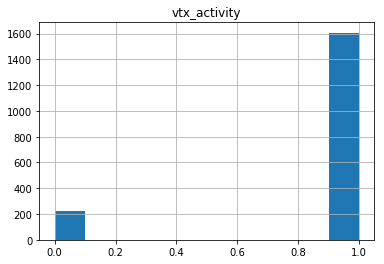

In [8]:
df = pd.read_pickle("../Input/lee/lee_shower_10.pckl")
df[["bnbweight","matched_showers_energy","vtx_activity"]][15:30]
df.hist("vtx_activity")


In [17]:
df = pd.read_pickle("../Input/lee_75k/lee_75k_track_1.pckl")
df[["track_energy_w","matched_tracks_energy","vtx_activity"]].head(15)

,track_energy_w,matched_tracks_energy,vtx_activity
0,0.872566,2.372413,1.0
1,0.148040,0.642272,1.0
2,0.163367,1.180757,1.0
3,0.136899,0.300300,1.0
4,0.018933,0.315290,1.0
5,0.164246,1.241118,1.0
6,0.096505,1.116180,1.0
7,0.072682,1.144089,1.0
8,0.126519,1.149594,1.0
9,0.057444,1.074577,1.0
